In [1]:
# https://github.com/jukyellow/algoTrade/tree/master/ch08/8.2%20RNN%EC%9D%84%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EC%A3%BC%EA%B0%80%20%EB%B0%A9%ED%96%A5%EC%84%B1%20%EB%B6%84%EB%A5%98%20%EC%98%88%EC%B8%A1


In [2]:
# 모델링에서 사용한 변수
# 1. 가격 데이터: 시가/고가/저가/거래량/로그수익률 등
# 2. 기술지표 데이터: 이동평균/이동표준편차(5,10일), 볼린저밴드, ATR(주식의 변동성 측정값), 1개월모멘텀(한달전가격과 현재의 가격차이), CCI(사이클트렌드오실레이터),3개월모멘텀 변동비율,MACD(모멘텀트렌드지표), 매수/매도스트레스측정
# 3. 시장데이터: S&P 500, 반도체(SOX)지수, 변동성지수(VIX)

In [3]:
#  절차
# 1. Raw데이터 불러오기
# 2. 데이터 가공 및 결합하기
# 3. 훈련,검증,테스트 데이터넷 분리하기
# 4. 학습에 용이하도록 데이터 정규화
# 5. 특성데이터/레이블 데이터 나누기

In [4]:
# https://github.com/tensortrade-org/tensortrade/issues/38
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib

# (2020) https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

(Reading database ... 161006 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [5]:
import pandas as pd 
import pandas_datareader as pdr
import talib 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import tensorflow as tf
import random as python_random

seed_number = 7
np.random.seed(seed_number)
python_random.seed(seed_number)
#tf.set_random_seed(seed_number) # v1
tf.random.set_seed(seed_number) # v2

In [6]:
# import pandas as pd
# import pandas_datareader as pdr
# intc_df = pdr.get_data_yahoo('INC', start='2000-01-01')
# sox_df = pdr.get_data_yahoo('^SOX', start='2000-01-01')
# vix_df = pdr.get_data_yahoo('^VIX', start='2000-01-01')
# snp500_df = pdr.get_data_yahoo('^GSPC', start='2000-01-01')
# intc_df.to_csv('intc.csv')
# sox_df.to_csv('sox.csv')
# vix_df.to_csv('vix.csv')
# snp500_df.to_csv('s&p500.csv')

# data Load
df = pd.read_csv('/content/intc.csv', index_col='Date', parse_dates=True)
sox_df = pd.read_csv('/content/sox_df.csv', index_col='Date', parse_dates=True)
vix_df = pd.read_csv('/content/vix_df.csv', index_col='Date', parse_dates=True)
snp500_df = pd.read_csv('/content/s&p500.csv', index_col='Date', parse_dates=True)

In [7]:
# 기술지표 추출
# data Feature
df['next_price'] = df['Adj Close'].shift(-1) # 다음날 수익률 예측: 다음날 시가와 종가간의 수정종가를 하루 미뤄줌
df['next_rtn'] = df['Close'] / df['Open'] -1
df['log_return'] = np.log(1 + df['Adj Close'].pct_change())
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

#1.RA(이동평균션) : Standard deviation rolling average
# Moving Average
df['MA5'] = talib.SMA(df['Close'],timeperiod=5)
df['MA10'] = talib.SMA(df['Close'],timeperiod=10)
df['RASD5'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=5)
df['RASD10'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=10)

#2.MACD : Moving Average Convergence/Divergence
macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd 

# Momentum(모멘텀) Indicators
#3.CCI : Commodity Channel Index
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)
# Volatility Indicators 

#4.ATR(변동성) : Average True Range
df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

#5.BOLL(볼린저 밴드) : Bollinger Band
upper, middle, lower = talib.BBANDS(df['Close'],timeperiod=20,nbdevup=2,nbdevdn=2,matype=0)
df['ub'] = upper
df['middle'] = middle
df['lb'] = lower

#7.MTM1 
df['MTM1'] = talib.MOM(df['Close'], timeperiod=1)

#7.MTM3
df['MTM3'] = talib.MOM(df['Close'], timeperiod=3)

#8.ROC : Rate of change : ((price/prevPrice)-1)*100
df['ROC'] = talib.ROC(df['Close'], timeperiod=60)

#9.WPR : william percent range (Williams' %R)
df['WPR'] = talib.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)

df.head()

,High,Low,Open,Close,Volume,Adj Close,next_price,next_rtn,log_return,CCI,MA5,MA10,RASD5,RASD10,MACD,ATR,ub,middle,lb,MTM1,MTM3,ROC,WPR
Date,,,,,,,,,,,,,,,,,,,,,,,
1999-12-31,41.9375,40.96875,41.906250,41.15625,11572000.0,26.504349,28.013699,-0.017897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,43.6875,41.62500,41.632812,43.50000,57710200.0,28.013699,26.705585,0.044849,0.055385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.34375,NaN,NaN,NaN
2000-01-04,43.9375,41.12500,42.718750,41.46875,51019600.0,26.705585,26.926966,-0.029261,-0.047821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.03125,NaN,NaN,NaN
2000-01-05,42.9375,40.25000,41.500000,41.81250,52389000.0,26.926966,25.357227,0.007530,0.008255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.34375,0.65625,NaN,NaN
2000-01-06,41.6875,39.09375,40.875000,39.37500,55171200.0,25.357227,26.403713,-0.036697,-0.060064,NaN,41.4625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.43750,-4.12500,NaN,NaN


In [8]:
#시장지수 데이터 추가
snp500_df = snp500_df.loc[:,['Close']].copy()
snp500_df.rename(columns={'Close':'S&P500'},inplace=True) #컬럼명 변경(컬럼명 중복문제 회피)
sox_df = sox_df.loc[:,['Close']].copy()
sox_df.rename(columns={'Close':'SOX'},inplace=True)
vix_df = vix_df.loc[:,['Close']].copy()
vix_df.rename(columns={'Close':'VIX'},inplace=True)

df = df.join(snp500_df,how='left') # 데이터 결합
df = df.join(sox_df,how='left')
df = df.join(vix_df,how='left')

df.head()

,High,Low,Open,Close,Volume,Adj Close,next_price,next_rtn,log_return,CCI,MA5,MA10,RASD5,RASD10,MACD,ATR,ub,middle,lb,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-12-31,41.9375,40.96875,41.906250,41.15625,11572000.0,26.504349,28.013699,-0.017897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1469.250000,704.559998,24.639999
2000-01-03,43.6875,41.62500,41.632812,43.50000,57710200.0,28.013699,26.705585,0.044849,0.055385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.34375,NaN,NaN,NaN,1455.219971,713.200012,24.209999
2000-01-04,43.9375,41.12500,42.718750,41.46875,51019600.0,26.705585,26.926966,-0.029261,-0.047821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.03125,NaN,NaN,NaN,1399.420044,687.320007,27.010000
2000-01-05,42.9375,40.25000,41.500000,41.81250,52389000.0,26.926966,25.357227,0.007530,0.008255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.34375,0.65625,NaN,NaN,1402.109985,678.539978,26.410000
2000-01-06,41.6875,39.09375,40.875000,39.37500,55171200.0,25.357227,26.403713,-0.036697,-0.060064,NaN,41.4625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.43750,-4.12500,NaN,NaN,1403.449951,669.330017,25.730000


In [9]:
# feature list
# feature_list = ['Adj Close', 'log_return', 'CCI','next_price']
feature1_list = ['Open','High','Low','Adj Close','Volume','log_return']
feature2_list = ['RASD5','RASD10','ub','lb','CCI','ATR','MACD','MA5','MA10','MTM1','MTM3','ROC','WPR']
feature3_list = ['S&P500', 'SOX', 'VIX']
# feature4_list = ['next_price']
feature4_list = ['next_rtn']

all_features = feature1_list + feature2_list + feature3_list + feature4_list

In [10]:
# 학습/검증/테스트 구간 분리
# 학습2년, 검증/테스트 3개월

phase_flag = '3'

if phase_flag == '1' :
    train_from = '2010-01-04'
    train_to = '2012-01-01'

    val_from = '2012-01-01'
    val_to = '2012-04-01'

    test_from = '2012-04-01'
    test_to = '2012-07-01'

elif phase_flag == '2' :
    train_from = '2012-07-01'
    train_to = '2014-07-01'

    val_from = '2014-07-01'
    val_to = '2014-10-01'

    test_from = '2014-10-01'
    test_to = '2015-01-01'
    
else : 
    train_from = '2015-01-01'
    train_to = '2017-01-01'

    val_from = '2017-01-01'
    val_to = '2017-04-01'

    test_from = '2017-04-01'
    test_to = '2017-07-01'

In [11]:
# train / validation / testing
train_df  = df.loc[train_from:train_to,all_features].copy()
val_df = df.loc[val_from:val_to,all_features].copy()
test_df   = df.loc[test_from:test_to,all_features].copy()

train_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,CCI,ATR,MACD,MA5,MA10,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX,next_rtn
Date,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,36.669998,37.160000,36.110001,31.625349,23605600.0,0.001927,0.360369,0.422398,37.964195,35.625804,-31.453150,0.695825,0.303488,36.828,36.961,0.070000,-0.820000,8.634596,-57.261459,2058.199951,686.729980,17.790001,-0.008454
2015-01-05,36.200001,36.450001,35.939999,31.268734,32785000.0,-0.011340,0.359143,0.416504,37.902114,35.536885,-87.370255,0.682552,0.216350,36.508,36.854,-0.410000,-0.809998,4.902248,-74.273902,2020.579956,673.590027,19.920000,-0.006906
2015-01-06,36.080002,36.230000,35.259998,30.685978,30847600.0,-0.018813,0.429746,0.417354,37.855069,35.344930,-141.831811,0.703084,0.092167,36.128,36.745,-0.670002,-1.010002,4.937537,-99.193531,2002.609985,658.830017,21.120001,-0.022173
2015-01-07,35.639999,36.070000,35.270000,31.329620,27725200.0,0.020758,0.449678,0.396641,37.788620,35.293380,-114.324726,0.710006,0.052853,35.980,36.626,0.740002,-0.340000,12.879977,-69.354794,2025.900024,665.270020,19.309999,0.010662
2015-01-08,36.369999,37.000000,36.259998,31.912374,31765400.0,0.018430,0.450896,0.396890,37.770449,35.291550,-11.701877,0.729292,0.074897,36.060,36.552,0.669998,0.739998,16.587224,-42.338775,2062.139893,684.650024,17.010000,0.008798


In [12]:
# data 정규화
def min_max_normal(tmp_df):
    eng_list = []
    sample_df = tmp_df.copy()
    for x in all_features:
        if x in feature4_list :
            continue
        series = sample_df[x].copy()
        values = series.values
        values = values.reshape((len(values), 1))
        # train the normalization
        scaler = MinMaxScaler(feature_range=(0, 1)) #최소,최대 정규화
        scaler = scaler.fit(values)
#         print('columns : %s , Min: %f, Max: %f' % (x, scaler.data_min_, scaler.data_max_))
        # normalize the dataset and print
        normalized = scaler.transform(values)
        new_feature = '{}_normal'.format(x)
        eng_list.append(new_feature)
        sample_df[new_feature] = normalized
    return sample_df, eng_list

In [19]:
train_sample_df, eng_list =  min_max_normal(train_df)
val_sample_df, eng_list =  min_max_normal(val_df)
test_sample_df, eng_list = min_max_normal(test_df)

In [20]:
print(train_sample_df.head())
print(eng_list)

                 Open       High  ...  SOX_normal  VIX_normal
Date                              ...                        
2015-01-02  36.669998  37.160000  ...    0.335631    0.221242
2015-01-05  36.200001  36.450001  ...    0.301055    0.293519
2015-01-06  36.080002  36.230000  ...    0.262216    0.334238
2015-01-07  35.639999  36.070000  ...    0.279162    0.272820
2015-01-08  36.369999  37.000000  ...    0.330158    0.194774

[5 rows x 45 columns]
['Open_normal', 'High_normal', 'Low_normal', 'Adj Close_normal', 'Volume_normal', 'log_return_normal', 'RASD5_normal', 'RASD10_normal', 'ub_normal', 'lb_normal', 'CCI_normal', 'ATR_normal', 'MACD_normal', 'MA5_normal', 'MA10_normal', 'MTM1_normal', 'MTM3_normal', 'ROC_normal', 'WPR_normal', 'S&P500_normal', 'SOX_normal', 'VIX_normal']


In [21]:
# LSTM Model 훈련데이터 구분하기
num_step = 5
num_unit = 200

def create_dateset_binary(data, feature_list, step, n):
    '''
    다음날 시종가 수익률 라벨링.
    '''
    train_xdata = np.array(data[feature_list[0:n]])
    
    # 가장 뒤 n step을 제외하기 위해. 왜냐하면 학습 input으로는 어차피 10개만 주려고 하니깐.
    m = np.arange(len(train_xdata) - step)
    #     np.random.shuffle(m)  # shufflee은 빼자.
    x, y = [], []
    for i in m:
        a = train_xdata[i:(i+step)] # 각 단계마다 사용할 학습데이터 기간
        x.append(a)
    x_batch = np.reshape(np.array(x), (len(m), step, n)) # 신경망 변수로 변경(data, batch_size, dimension?)
    
    train_ydata = np.array(data[[feature_list[n]]]) #레이블링 Data(종가)
    # n_step 이상부터 답을 사용할 수 있는거니깐. 
    for i in m + step :
        next_rtn = train_ydata[i][0]
        if next_rtn > 0 :
            label = 1
        else :
            label = 0
        y.append(label)
    y_batch = np.reshape(np.array(y), (-1,1))
    return x_batch, y_batch

In [22]:
eng_list = eng_list + feature4_list
n_feature = len(eng_list)-1
# LSTM할때 사용했던 소스코드.
x_train, y_train = create_dateset_binary(train_sample_df[eng_list], eng_list, num_step, n_feature)
x_val, y_val = create_dateset_binary(val_sample_df[eng_list], eng_list, num_step, n_feature)
x_test, y_test = create_dateset_binary(test_sample_df[eng_list], eng_list, num_step, n_feature)

print(x_train[0:1])
print()
print(y_train[0:2])

[[[0.87892706 0.89295266 0.86262465 0.71857449 0.17448571 0.61890837
   0.2833929  0.39743783 0.87320767 0.89599294 0.47126977 0.49100894
   0.61170464 0.90072938 0.92654924 0.62244902 0.4087722  0.62416874
   0.42738541 0.51762152 0.33563134 0.22124195]
  [0.84291193 0.82961644 0.84957768 0.68880907 0.26491548 0.53456841
   0.28217796 0.39023861 0.86673075 0.88766971 0.37849591 0.46770197
   0.57672604 0.87226472 0.91613967 0.52448996 0.41052696 0.55239843
   0.25726098 0.43263147 0.30105525 0.29351881]
  [0.83371661 0.809991   0.7973904  0.64016845 0.24582942 0.48706551
   0.35217903 0.39127686 0.86182254 0.86970184 0.28813699 0.50375553
   0.52687678 0.83846288 0.90553553 0.47142832 0.37543844 0.55307702
   0.00806469 0.39203421 0.26221618 0.33423821]
  [0.79999994 0.79571805 0.79815803 0.69389104 0.21506946 0.73861726
   0.37194101 0.3659754  0.85488983 0.86487649 0.33377488 0.51591121
   0.51109566 0.825298   0.89395854 0.75918408 0.49298263 0.70580428
   0.30645206 0.44465042 0.2

In [23]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

print(pd.DataFrame(y_train).sum())
print(pd.DataFrame(y_val).sum())
print(pd.DataFrame(y_test).sum())

0    229.0
1    270.0
dtype: float32
0    29.0
1    28.0
dtype: float32
0    31.0
1    27.0
dtype: float32


In [25]:
x_train.shape

(499, 5, 22)

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

In [27]:
# LSTM 모델을 생성한다.
K.clear_session()
input_layer = Input(batch_shape=(None, x_train.shape[1], x_train.shape[2]))
layer_lstm_1 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(input_layer)
layer_lstm_1 = BatchNormalization()(layer_lstm_1)
layer_lstm_2 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_1)
layer_lstm_2 = Dropout(0.25)(layer_lstm_2)
layer_lstm_3 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_2)
layer_lstm_3 = BatchNormalization()(layer_lstm_3)
layer_lstm_4 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_3)
layer_lstm_4 = Dropout(0.25)(layer_lstm_4)
layer_lstm_5 = LSTM(num_unit , recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_4)
layer_lstm_5 = BatchNormalization()(layer_lstm_5)
output_layer = Dense(2, activation='sigmoid')(layer_lstm_5)

model = Model(input_layer, output_layer)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

#https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/ 이 말인 즉슨 LSTM이 자체 gate 별 활성화 함수를 갖고있다

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 22)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 200)            178400    
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 200)            800       
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 200)            320800    
_________________________________________________________________
dropout (Dropout)            (None, 5, 200)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 200)            320800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 200)            800   

In [28]:
y_val.shape

(57, 2)

In [29]:
history = model.fit(x_train,y_train,epochs=20, batch_size=10, validation_data=(x_val, y_val))

Epoch 1/20
50/50 [==============================] - 22s 38ms/step - loss: 8.4596 - accuracy: 0.4886 - val_loss: 3.0937 - val_accuracy: 0.4912
Epoch 2/20
50/50 [==============================] - 1s 10ms/step - loss: 2.5541 - accuracy: 0.5716 - val_loss: 1.5076 - val_accuracy: 0.4912
Epoch 3/20
50/50 [==============================] - 1s 10ms/step - loss: 1.3647 - accuracy: 0.5289 - val_loss: 1.0116 - val_accuracy: 0.5614
Epoch 4/20
50/50 [==============================] - 1s 10ms/step - loss: 1.0026 - accuracy: 0.5790 - val_loss: 0.8377 - val_accuracy: 0.5614
Epoch 5/20
50/50 [==============================] - 0s 10ms/step - loss: 0.8406 - accuracy: 0.5642 - val_loss: 0.7616 - val_accuracy: 0.5263
Epoch 6/20
50/50 [==============================] - 0s 10ms/step - loss: 0.8034 - accuracy: 0.5353 - val_loss: 0.7628 - val_accuracy: 0.4561
Epoch 7/20
50/50 [==============================] - 0s 10ms/step - loss: 0.7770 - accuracy: 0.5166 - val_loss: 0.7513 - val_accuracy: 0.4386
Epoch 8/20
5

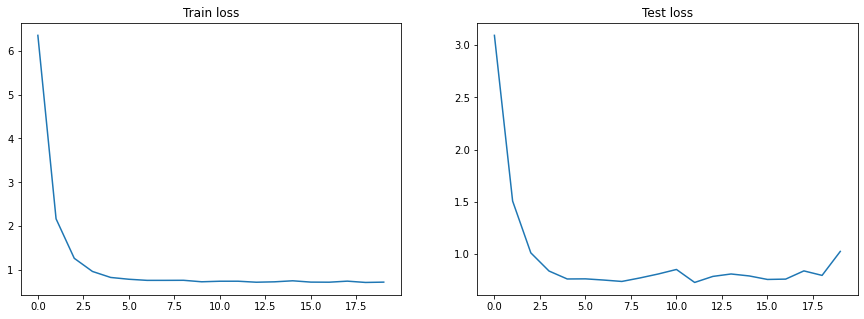

In [30]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    plt.savefig('sample.png')

plot_history(history) # 3단계

In [31]:
# 예측

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

predicted = model.predict(x_test)
y_pred = np.argmax(predicted, axis=1)
Y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(Y_test, y_pred)
report = classification_report(Y_test, y_pred)

In [32]:
# ROC AUC 커브 만들어보기

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

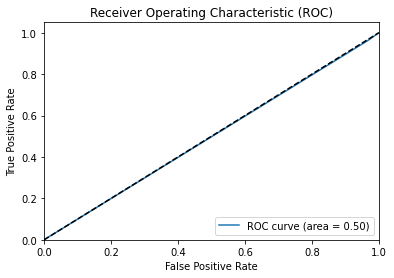

ROC AUC 값 : 0.4976


In [33]:
plot_roc(y_pred,Y_test)
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

In [34]:
# Drop & Batch
y_pred

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [35]:
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp = cm[0][1]
if tp == 0:
    tp = 1
if tn == 0:
    tn = 1
if fp == 0:
    fp = 1
if fn == 0:
    fn = 1
TPR = float(tp)/(float(tp)+float(fn))
FPR = float(fp)/(float(fp)+float(tn))
accuracy = round((float(tp) + float(tn))/(float(tp) +
                                          float(fp) + float(fn) + float(tn)), 3)
specitivity = round(float(tn)/(float(tn) + float(fp)), 3)
sensitivity = round(float(tp)/(float(tp) + float(fn)), 3)
mcc = round((float(tp)*float(tn) - float(fp)*float(fn))/math.sqrt(
    (float(tp)+float(fp))
    * (float(tp)+float(fn))
    * (float(tn)+float(fp))
    * (float(tn)+float(fn))
), 3)

f_output = open('binary_lstm_open_close_phase3_dropout_batch_Normal_3단계 test.txt', 'a')
f_output.write('=======\n')
f_output.write('{}epochs_{}batch\n'.format(
    20, 10))
f_output.write('TN: {}\n'.format(tn))
f_output.write('FN: {}\n'.format(fn))
f_output.write('TP: {}\n'.format(tp))
f_output.write('FP: {}\n'.format(fp))
f_output.write('TPR: {}\n'.format(TPR))
f_output.write('FPR: {}\n'.format(FPR))
f_output.write('accuracy: {}\n'.format(accuracy))
f_output.write('specitivity: {}\n'.format(specitivity))
f_output.write("sensitivity : {}\n".format(sensitivity))
f_output.write("mcc : {}\n".format(mcc))
f_output.write("{}".format(report))
f_output.write('=======\n')
f_output.close()

In [36]:
# 예측.
# y_hat = model.predict(x_test, batch_size = 1)
print(len(y_test))
print(len(y_pred))

58
58


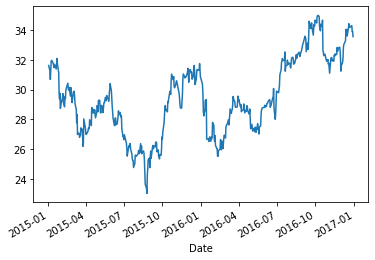

In [37]:
train_sample_df['Adj Close'].plot()

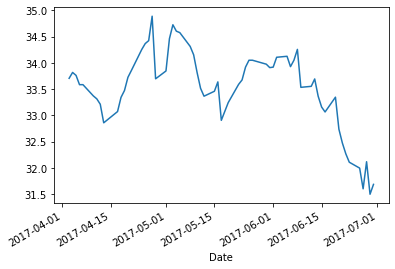

In [38]:
test_sample_df['Adj Close'].plot()

In [39]:
# 3단계 
lstm_book_df = test_sample_df[['Adj Close','next_rtn']].copy()
# ### 이 문제에 있어서 Series와 DataFrame의 차이는 뭐지?
t1 = pd.DataFrame(data = y_pred,columns=['position'],index = lstm_book_df.index[5:])
lstm_book_df = lstm_book_df.join(t1,how='left')
lstm_book_df.fillna(0,inplace=True)
lstm_book_df['ret'] = lstm_book_df['Adj Close'].pct_change()
lstm_book_df['lstm_ret'] = lstm_book_df['next_rtn'] * lstm_book_df['position'].shift(1)
lstm_book_df['lstm_cumret'] = (lstm_book_df['lstm_ret'] + 1).cumprod()
lstm_book_df['bm_cumret'] = (lstm_book_df['ret'] + 1).cumprod()

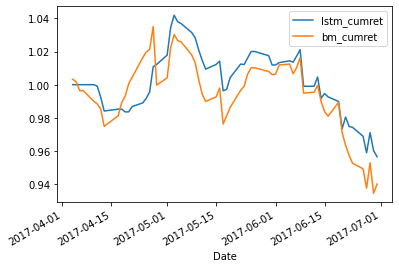

In [40]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

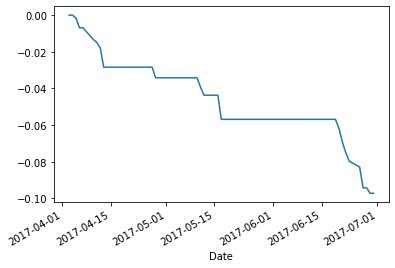

In [42]:
# 백테스트팅
historical_max = lstm_book_df['Adj Close'].cummax()
daily_drawdown = lstm_book_df['Adj Close'] / historical_max - 1.0
historical_dd = daily_drawdown.cummin()
historical_dd.plot()

In [46]:
lstm_book_df.head()

,Adj Close,next_rtn,position,ret,lstm_ret,lstm_cumret,bm_cumret
Date,,,,,,,
2017-04-03,33.705460,-0.000829,0.0,NaN,NaN,NaN,NaN
2017-04-04,33.817307,0.004430,0.0,0.003318,0.0,1.0,1.003318
2017-04-05,33.761391,-0.005764,0.0,-0.001653,-0.0,1.0,1.001659
2017-04-06,33.584286,-0.002768,0.0,-0.005246,-0.0,1.0,0.996405
2017-04-07,33.584286,-0.001109,0.0,0.000000,-0.0,1.0,0.996405


In [43]:
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'bm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['ret']) / np.std(lstm_book_df['ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  -21.92 %
Sharpe :  -1.62
VOL :  14.82 %
MDD :  9.73 %


In [44]:
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'lstm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['lstm_ret']) / np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  -16.3 %
Sharpe :  -1.61
VOL :  10.88 %
MDD :  9.73 %
